In [1]:
import numpy as np
from importlib import reload
from scipy import signal

import plotting_tools as pt
import utils
import dsi
utils = reload(utils)
pt = reload(pt)
dsi = reload(dsi)

import pickle
import sys
# Notebook needs to see the RKLM_Python module to load pickled class instances
sys.path.append('../RKLM_Python/')

from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
from matplotlib import rc

# activate latex text rendering
rc('text', usetex=True)

In [5]:
Nx, Ny = 601, 20
# Nx, Ny = 1201, 80
ib = False

N = 1
fac = 1.0 # how many plots?

def load(Nx,Ny,et,test):
    if test == 'mark':
        base_fn = 'output_mark_wave'
    elif test == 'lamb':
        base_fn = 'output_lamb_wave'
    pydir = '../%s/' %base_fn

    tc = utils.test_case(base_fn, pydir, Nx, Ny, et)
    tags = tc.get_tag_dict()
    
    return tc, tags

i2 = (slice(2,-2),slice(2,-2))

# Helper funcs

In [6]:
def get_ens(tc, times, sfx , diff, attribute, tag):
    idx = 0 if tag == 'ic' else -1
    times = [0] if tag == 'ic' else times
    ens = tc.get_ensemble(times, N, attribute, sfx, label_type=l_typ, avg=True, diff=diff, tag=tag, inner=False,load_ic=True)[idx]

    label = sfx + '_' + attribute
    return label, ens.T

def get_ens_all(tc, times, sfx , diff, attribute, tag):
    ens = tc.get_ensemble(times, N, attribute, sfx, label_type=l_typ, avg=True, diff=diff, tag=tag, inner=False,load_ic=True)
    return ens

def get_arr(typ, times, tp='half', test='mark', et=8000.0):
    sfx1 = '%s' %typ
    if ib: sfx1 = '%s_ib-0' %sfx1
    print(sfx1, typ)

    tc, tags = load(Nx,Ny,et,test)
    if tp=='afs':
        tag = 'after_full_step'
    else:
        tag = tp

    # load pickled instances of data used in simulation
    fn_pickle = tc.get_filename(N,sfx1,format='dat')
    path_pickle = tc.get_path(fn_pickle)

#     print(path_pickle)
    file = open(path_pickle,'rb')
    ud = pickle.load(file)
    mpv = pickle.load(file)
    dap = pickle.load(file)
    elem = pickle.load(file)
    file.close()
    
#     print(tag)

    S0 = (ud.stratification(elem.y)).reshape(-1,1)
    
    attributes = ['rhoX','rhou', 'rhov', 'rhoY', 'p2_nodes']
    _, rho = get_ens(tc, times, sfx1, diff, 'rho', tag)
    la = r'BB: '
    if 'best' in typ:
        la += r'\textbf{CS}'
    elif 'imbal' in typ:
        la += r'\textbf{NS}'
    else:
        la += r'\textbf{ref}'
#     la = la + '_' + typ
    ret = []
    
    rho_pl = rho[i2] #* ud.rho_ref
    ret.append([rho_pl,la + r' ($\rho$)'])
    
    for attribute in attributes:
        _, aa = get_ens(tc, times, sfx1, diff, attribute, tag)
        if attribute == 'rhoY':
            la_curr = la + r' ($\Theta^\prime$)'
        elif attribute == 'rhov':
            la_curr = la + r' ($w$)'
        elif attribute == 'rhou':
            la_curr = la + r' ($u$)'
        elif attribute == 'rhoX':
            la_curr = la + r' ($\chi^\prime$)'
        else:
            la_curr = la + r' ($\pi^\prime$)'
        
        if attribute == 'rhoY':
            aa = aa / rho
            aa -= S0
            aa = aa[i2] #* ud.T_ref
        elif attribute == 'rhou':
            aa = aa / rho
            aa = aa[i2] #* ud.u_ref
        elif attribute == 'rhov':
            aa = aa / rho
            aa = aa[i2] #* ud.u_ref
        elif attribute == 'rhoX':
            aa = aa / rho
            aa = aa[i2] #/ ud.T_ref
        elif attribute == 'p2_nodes':
            aa = aa[i2]
            
        ret.append([aa,la_curr])
    
    return np.array(ret), ud, tc

# old Lamb plotter

In [20]:
l_typ = 'WINDOW_STEP'
diff = False

attr_labels = pt.labels()

typ1 = 'debug_ic'

times0 = [984]

tp = 'ic' if times0[0] == 0 else 'afs'
aa1, ud = get_arr(typ1,times0, tp=tp, test='lamb')

pl_lst = aa1
pl = pt.plotter(pl_lst,ncols=2,figsize=(16*fac,10*fac),sharey=False)
    
x_axs = np.array(np.linspace(ud.xmin,ud.xmax,7))
# y_axs = [-0.5,-0.25,0.0,0.25,0.5]
y_axs = np.array(np.linspace(ud.ymin,ud.ymax,6))

print(x_axs*ud.h_ref)
print(y_axs*ud.h_ref)
x_axs = np.around(x_axs,3)
y_axs = np.around(y_axs,1)

x_loc = np.linspace(0,Nx-1,7)
y_loc = np.linspace(0,Ny-1,6)
x_label = r'x [$\times 10$ km]'
y_label = r'y [$\times 10$ km]'

# pl.set_axes(y_locs=y_loc,y_axs=y_axs, x_locs=x_loc,x_axs=x_axs)
pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, x_label=x_label, y_label=y_label)
_ = pl.plot(method='contour', lvls=None)

# lbl = 'swe' if swe else 'euler'
# pl.save_fig('initial_vortex_%s' %lbl)

debug_ic debug_ic


/home/ray/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


ValueError: too many values to unpack (expected 2)

In [477]:
1174//20

58

# New Lamb plotter

debug_ic_test debug_ic_test


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


[ 0.6  1.2  1.8  2.4  3.   3.6  4.2  4.8  5.4  6.   6.6  7.2  7.8  8.4
  9.   9.6 10.2 10.8 11.4 12.  12.6 13.2 13.8 14.4 15.  15.6 16.2 16.8
 17.4 18.  18.6 19.2 19.8 20.4 21.  21.6 22.2 22.8 23.4 24.  24.6 25.2
 25.8 26.4 27.  27.6 28.2 28.8 29.4]
0.6
debug_ic_test debug_ic_test


/home/ray/git-projects/RKLM_Reference/visualiser_debugger/plotting_tools.py:99: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(im, cax=bax, extend='both', extendrect=True, extendfrac='auto')#, format='%.3f')


NameError: name 'tu' is not defined

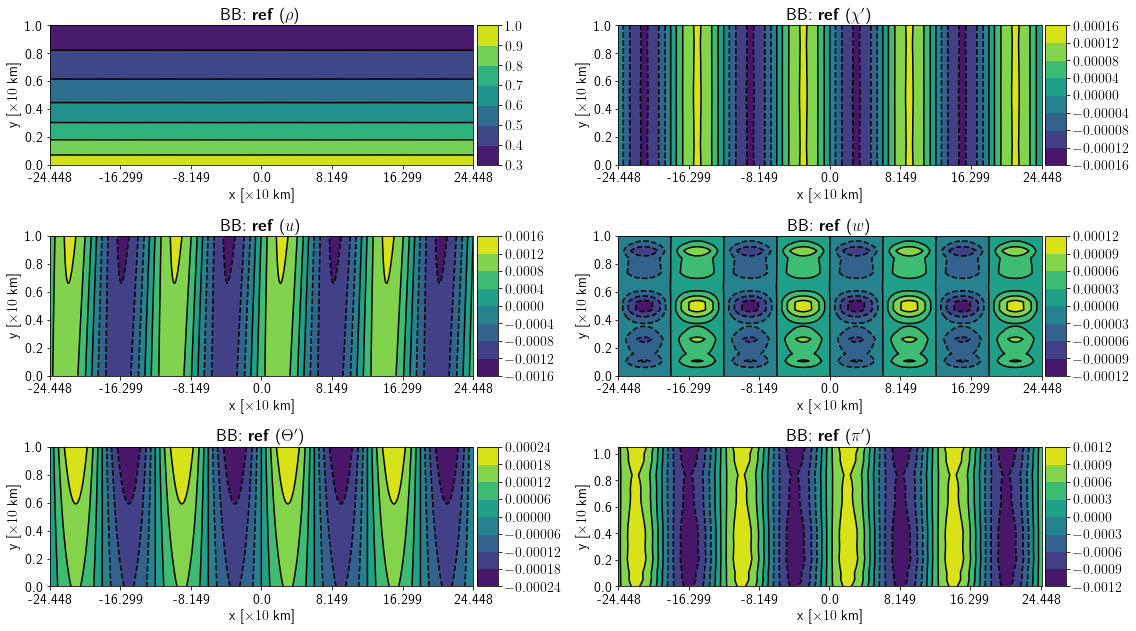

In [10]:
l_typ = 'WINDOW_STEP'
diff = False

attr_labels = pt.labels()

typ1 = 'debug_ic_8hrho'
typ1 = 'debug_ic_k1_om'
typ1 = 'debug_ic_om_rsts'
# typ1 = 'debug_ic_noom_rsts'
# typ1 = 'debug_ic_om_hrs'
typ1 = 'debug_ic_noom_hrs'
# typ1 = 'debug_ic_short_om_rsts'
# typ1 = 'debug_ic_noom_hrs'
typ1 = 'debug_ic_test'

def file_namer(ttype, sttype):
    if len(ttype) > 0:
        ttype += '_'
    typ1 = 'debug_ic_%som_%s' %(ttype,sttype)
    typ2 = 'debug_ic_%snoom_%s' %(ttype,sttype)
    return typ1, typ2

# typ1, typ2 = file_namer('','vlarge')

times0 = [984]
# times0 = [200]
# times0 = [899]
# times0 = np.arange(3600)
# times0 = np.arange(0,210,10)
# times0 = np.arange(89)
times0 = np.arange(89)
tp ='afs'
tag = 'after_full_step'
# tu = ud.t_ref
time_unit = 's'

long = 'long' in typ1 or 'short' in typ1

# if long:
l_typ = 'TIME'
times0 = np.arange(0.0,720.0+0.6,0.6)[1:50]
# times0 = np.arange(0.0,720.0+0.01,0.01)[1:50]
    
_,_,tc = get_arr(typ1,times0, tp=tp, et=720.0)
_ = get_ens_all(tc, times0, typ1, False, 'rho', tag)[:]

# if long:
t_axs = np.append(0,times0)
# else:
#     idxs = []
#     t_axs = np.array(tc.t_arr)[1:]
#     t_axs = np.around(t_axs,0)
# #     val = len(times0)//20
# #     idxs = times0[1:][::val]
#     idxs = np.where(t_axs % 36 == 0)
#     idxs = np.append(0,idxs)
#     times0 = times0[idxs]
#     times0 = np.arange(10)
    
print(times0)
# print(t_axs)
# tp = 'ic'
if '_om_' in typ1:
    tcase = 'w_omega'
    tstr = r'7.292 \times 10^{-5}'
elif '_noom_' in typ1:
    tcase = 'wo_omega'
    tstr = r'0.0'
else:
    tcase = ''
    tstr = r'...'

lrho = np.arange(0.32,0.96+0.08,0.08)
lrhoX = np.arange(-0.00016,0.00016+0.00004,0.00004)
lu = np.arange(-0.0016,0.0016+0.0004,0.0004)
lv = np.arange(-0.00016,0.00016+0.00004,0.00004)
lrhoY = np.arange(1.0,1.45,0.05)
lp2n = np.arange(-0.001,0.00125,0.00025)
lvls = [lrho,lrhoX,lu,lv,lrhoY,lp2n]

for idx,time in enumerate(times0):
    print(time)
#     tp = 'ic' if time == 0 else 'afs'
    aa2,ud,_ = get_arr(typ1,[time], tp=tp, et=720.0)
#     if long:
    ct = 0.0 if time == 0 else time
#     else:
#         ct = 0.0 if time == 0 else t_axs[time]

    pl_lst = aa2
    pl = pt.plotter(pl_lst,ncols=2,figsize=(16*fac,10*fac),sharey=False)
    x_axs = np.array(np.linspace(ud.xmin,ud.xmax,7))
    # y_axs = [-0.5,-0.25,0.0,0.25,0.5]
    y_axs = np.array(np.linspace(ud.ymin,ud.ymax,6))

    x_axs = np.around(x_axs,3)
    y_axs = np.around(y_axs,1)

    x_loc = np.linspace(0,Nx-1,7)
    y_loc = np.linspace(0,Ny-1,6)
    x_label = r'x [$\times 10$ km]'
    y_label = r'y [$\times 10$ km]'

    # pl.set_axes(y_locs=y_loc,y_axs=y_axs, x_locs=x_loc,x_axs=x_axs)
    pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, x_label=x_label, y_label=y_label)
    
    if 'rsts' in typ1:
        time_unit = 's'
        tu = ud.t_ref
        stitle = r'$\Omega_y = %s s^{-1}$, time = %.2f %s' %(tstr, ct*tu, time_unit)
    elif 'hrs' in typ1 or long or 'min' in typ1 or 'vlarge' in typ1:
        time_unit = 'hrs'
        tu = ud.t_ref/3600
        stitle = r'$\Omega_y = %s s^{-1}$, time = %.2f %s' %(tstr, ct*tu, time_unit)
    else:
        stitle = ''
    _ = pl.plot(method='contour', lvls=None, suptitle=stitle, rect=[0, 0.03, 1, 0.95])

    pl.save_fig('./output_mark/lamb_%s_%.2f%s' %(tcase,ct*tu,time_unit), format='.png')
    plt.close()

# Diffs plotter

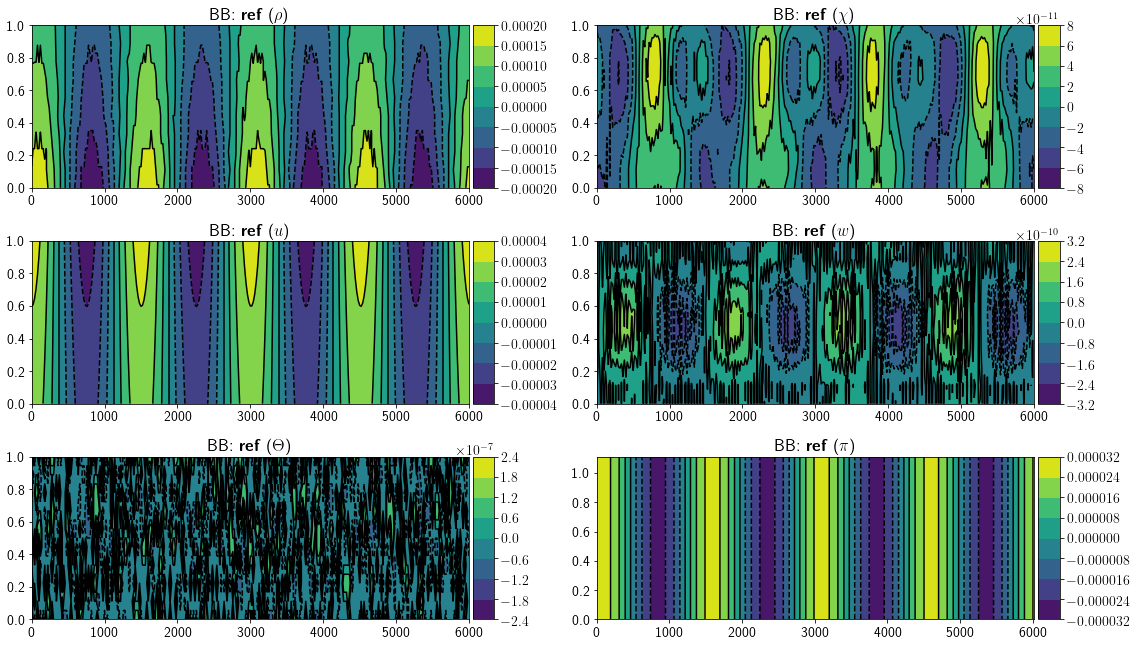

In [166]:
diffs = np.array([[aa[0]-aa2[ii][0],aa[1]] for ii,aa in enumerate(aa1)], dtype='object')

pl_lst = diffs
pl = pt.plotter(pl_lst,ncols=2,figsize=(16*fac,10*fac),sharey=False)
    
x_axs = np.array([0,1000,2000,3000,4000,5000,6000])
y_axs = np.array([0.0,2.0,4.0,6.0,8.0,10.0]) / 10.0
x_loc = np.linspace(0,Nx-1,7)
y_loc = np.linspace(0,Ny-1,6)

pl.set_axes(y_locs=y_loc,y_axs=y_axs, x_locs=x_loc,x_axs=x_axs)
_ = pl.plot(method='contour', lvls=None)

# Time series

debug_ic_om_vlarge debug_ic_om_vlarge
debug_ic_noom_vlarge debug_ic_noom_vlarge


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


0.1 15.25


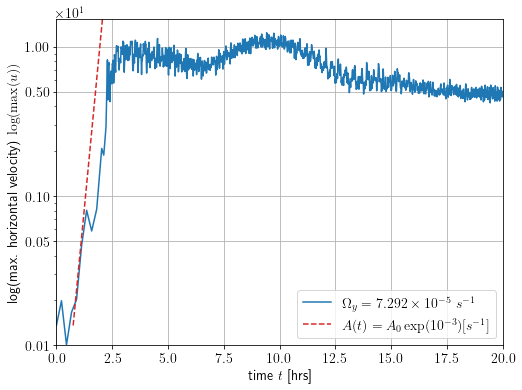

In [20]:
from matplotlib.ticker import (FixedLocator)
from matplotlib import ticker

l_typ = 'WINDOW_STEP'
diff = False

attr_labels = pt.labels()

def file_namer(ttype, sttype):
    if len(ttype) > 0:
        ttype += '_'
    typ1 = 'debug_ic_%som_%s' %(ttype,sttype)
    typ2 = 'debug_ic_%snoom_%s' %(ttype,sttype)
    return typ1, typ2

typ2 = 'debug_ic_noom_hrs'
typ1 = 'debug_ic_om_hrs'

# typ2 = 'debug_ic_noom_rsts'
# typ1 = 'debug_ic_om_rsts'

# typ1 = 'debug_ic_x100'

typ1, typ2 = file_namer('','vlarge')
# typ1, typ2 = file_namer('min60','min')

# typ1 = 'debug_ic_long_om_rsts'
# typ2 = 'debug_ic_long_noom_rsts'

# typ1 = 'debug_ic_short_om_rsts'
# typ2 = 'debug_ic_short_noom_rsts'

Nx, Ny = 301, 10
et = 8000.0
tc, tags = load(Nx,Ny,et,'mark')

nts = 100
times0 = np.arange(984)
times0 = np.arange(200)[:nts]
times0 = np.arange(900)
times1 = np.arange(1162)
times1 = np.arange(1173)
times2 = np.arange(89)
# times1 = np.arange(1111)
# times2 = np.arange(1107)
# times1 = np.arange(3836)
# times1 = np.arange(1174)
# times2 = np.arange(900)
# times1 = np.arange(800)
# times0 = np.arange(50)
# times1 = np.arange(50)
# times2 = np.arange(50)


long = 'long' in typ1 or 'short' in typ1 or 'min' in typ1
short = 'short' in typ1

if long:
#     l_typ = 'TIME'
#     times1 = np.arange(0.0,720.0+0.6,0.6)[1:51]
#     times1 = np.arange(0.0,720.0+0.01,0.01)[1:11]
#     times2 = times1
    pass

# tp = 'ic'
tp = 'ic' if times1[0] == 0 else 'afs'
attribute = 'rhou'
tag = 'after_full_step'

if 'hrs' in typ1 or long or 'vlarge' in typ1:
    _,_,tc1 = get_arr(typ1,times1, tp=tp, et=720.0)
    _,_,tc2 = get_arr(typ2,times2, tp=tp, et=720.0)        
    tt1 = times1
    tt2 = times2
else:
    _,_,tc1 = get_arr(typ1,times0, tp=tp, et=720.0)
    _,_,tc2 = get_arr(typ2,times0, tp=tp, et=720.0)
    tt1, tt2 = times0, times0

arrs = get_ens_all(tc1, tt1, typ1, False, attribute, tag)[:]
rhos = get_ens_all(tc1, tt1, typ1, False, 'rho', tag)[:]
t_axs1 = np.array(tc1.t_arr)

arrs_noom = get_ens_all(tc2, tt2, typ2, False, attribute, tag)[:]
rhos_noom = get_ens_all(tc2, tt2, typ2, False, 'rho', tag)[:]
t_axs2 = np.array(tc2.t_arr)

# if long:
#     t_axs1 = np.append(0,times1)
#     t_axs2 = np.append(0,times2)
#     print(t_axs1)

# print(t_axs1, t_axs2)

res = []
res_noom = []
for idx, arr in enumerate(arrs):
    u = arr / rhos[idx]
    res.append(u.max())
    
for idx, arr in enumerate(arrs_noom):
    u_noom = arr / rhos_noom[idx]
    res_noom.append(u_noom.max())
    
res = np.array(res)
res_noom = np.array(res_noom)

fig = plt.figure(figsize=(8,6))
fig.add_subplot(111)
ax = plt.gca()

t_axs = t_axs[:nts+1]
tt = t_axs1[:80]* ud.t_ref #/ 3600
# print(tt)
# print(res.shape)
# print(tt.shape)
hrs = 'hrs' in typ1 or 'vlarge' in typ1
vl = 'vlarge' in typ1
tu = ud.t_ref / 3600 if (hrs or (long and not short)) else ud.t_ref
ax.semilogy(t_axs1*tu, res*ud.u_ref, '-', label=r'$\Omega_y = 7.292 \times 10^{-5}~s^{-1}$')
# ax.semilogy(t_axs2*tu, res_noom*ud.u_ref, 'C2-', label=r'$\Omega_y = 0.0~s^{-1}$')

def fth(t):
    return ((res*ud.u_ref)[0]*np.exp(10**(-3)*t))

tty = fth(tt) 
# tty += (res*ud.u_ref)[0]
# print(tty)
tt = (tt / 3600)+5.0 if (hrs and not vl) else tt
tt = (tt / 3600)+1.25 if vl else tt
tt1 = (tt)-0.50 if vl else tt
tt = (tt / 3600)+23 if long and not short else tt
tt += 17000
if ((not hrs) and (len(times0) < 20) and (not long) or (short)):
    tt = (tt) + 1.0
    tt = tt[:-1]
    tty = tty[:-1]
else:
    tt
ax.semilogy(tt, tty, 'C3--', label=r'$A(t) = A_0 \exp(10^{-3})[s^{-1}]$')
ax.semilogy(tt1, tty, 'C3--', label=r'')

formatter = ticker.ScalarFormatter()
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.yaxis.set_major_formatter(formatter)
if hrs:
    pos = np.array([0.1,0.5,1.0,5.0,10.0])
    y_locator = FixedLocator(pos)
    ax.yaxis.set_major_locator(y_locator)
    ax.set_ylim([0.1,15.25])
    ax.set_xlim([0.0,20.0])
#     ax.set_ylim([0.1,0.2])
#     ax.set_xlim([0.0,1.0])
elif 'min60' in typ1:
#     pass
    pos = np.array([0.1,0.5,1.0,5.0])
    y_locator = FixedLocator(pos)
    ax.yaxis.set_major_locator(y_locator)    
    ax.set_ylim([0.1,10.0])
    ax.set_xlim([0.0,60.0])
elif long:
    pass
# elif len(times0) > 150 and not hrs:
#     pos = np.array(np.arange(1.2,2.1,0.1))*0.1
#     y_locator = FixedLocator(pos)
#     ax.yaxis.set_major_locator(y_locator)
#     ax.yaxis.set_minor_locator(FixedLocator([]))
#     ax.set_ylim([0.12,0.208])
#     ax.set_xlim([0.0,200.0])
# else:
#     pos = np.array(np.arange(1.362,1.378,0.002))*0.1
#     y_locator = FixedLocator(pos)
#     ax.yaxis.set_major_locator(y_locator)
#     ax.yaxis.set_minor_locator(FixedLocator([]))
#     ax.set_xlim([0.0,10.0])
    
    
# ax.set_xlim([0.0,1.0])
        
# test = (res*ud.u_ref * kGam * Omega)**0.5
# plt.plot(t_axs * ud.t_ref / 3600, test, '-')

# print((t_axs*ud.t_ref)[-1])

# plt.plot(times0 * dt * ud.t_ref, fth(times0 * dt * ud.t_ref))
ymin, ymax = plt.gca().get_ylim()
print(ymin, ymax)
# plt.ylim([-0.2,12.0])
# plt.ylim([1.37e-3,1.38e-3])
# plt.ylim([1.435e-3,1.438e-3])
ax.set_ylabel("log(max. horizontal velocity) $\log(\max(u))$")
t_units = 'hrs' if (hrs or (long and not short)) else 's'
ax.set_xlabel("time $t$ [%s]" %t_units)
ax.grid()
ax.legend()
plt.show()

In [265]:
np.exp(np.log(0.1362) + 0.01)

0.13756883275686368